In [2]:
# OS imports
import logging

# Standard imports
import numpy as np
import torch as tc
import matplotlib.pyplot as plt
from scipy.stats import norm, multivariate_normal
from scipy.optimize import curve_fit
import wandb

import random
# Project imports
import pyro
import pyro.distributions as dist
import pyro.distributions.constraints as constraints
from pyro.infer import Predictive, Importance, EmpiricalMarginal

In [22]:
# Weights & biases
# NOTE: Only turn this on when you think you have got everything working
wandb_run = False
if wandb_run:
    wandb.init(project='HW1-Q5', entity='cs532-2022')

wandb: Currently logged in as: elvis_cai (cs532-2022). Use `wandb login --relogin` to force relogin


Bayesian linear regression
```
(defn observe-data [_ data slope bias]
  (let [xn (first data)
        yn (second data)
        zn (+ (* slope xn) bias)]
    (observe (normal zn 1.0) yn)
    (rest (rest data))))
(let [slope (sample (normal 0.0 10.0))
      bias  (sample (normal 0.0 10.0))
      data  (vector 1.0 2.1 2.0 3.9 3.0 5.3
                   4.0 7.7 5.0 10.2 6.0 12.9)]
  (loop 6 data observe-data slope bias)
  (vector slope bias))
```

In [23]:
# Pyro settings
pyro.enable_validation(True)
pyro.set_rng_seed(1)
logging.basicConfig(format='%(message)s', level=logging.INFO)

In [24]:
# Data and parameters
# NOTE: You need to fill this in
x_numpy = range(1, 7)
y_numpy = [2.1, 3.9, 5.3, 7.7, 10.2, 12.9]
x_torch = tc.tensor(x_numpy)
y_torch = tc.tensor(y_numpy)
sigma = 10
alpha = 1

In [25]:
# Check model fitting (non Bayesian) with scipy
def f(x, bias, slope):
    return bias+x*slope
popt, pcov = curve_fit(f, x_numpy, y_numpy)
print('Best-fitting parameters:', popt)
print('Parameter covariance matrix:\n', pcov)

Best-fitting parameters: [-0.51333333  2.15142857]
Parameter covariance matrix:
 [[ 0.22686031 -0.05235238]
 [-0.05235238  0.01495782]]


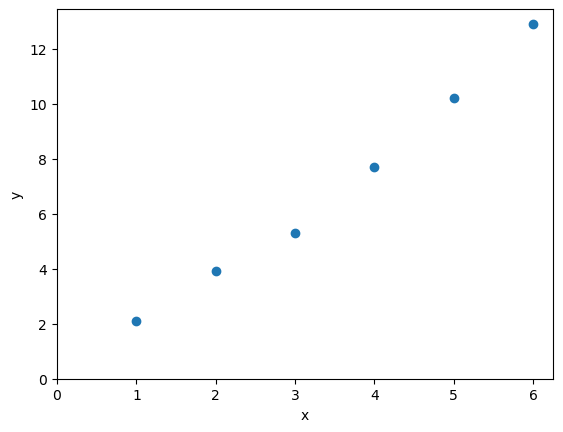

In [26]:
# Plot data
plt.plot(x_numpy, y_numpy, marker='o', ls='None')
plt.xlabel('x')
plt.xlim(left=0.)
plt.ylabel('y')
plt.ylim(bottom=0.)
plt.show()

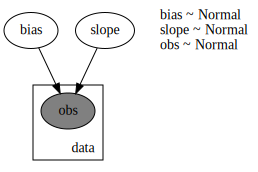

In [27]:
# Probabilistic model
# def model(x, y):
#     alpha = pyro.sample("alpha", dist.Normal(0., 10.))
#     w0 = pyro.sample("w0", dist.Normal(0., alpha))
#     w1 = pyro.sample("w1", dist.Normal(0., alpha))
#     sigma = pyro.sample("sigma", dist.Normal(0., 10.))
#     pred_mean = w0+w1*x
#     with pyro.plate("data", len(y)):
#         pyro.sample("obs", dist.Normal(pred_mean, sigma), obs=y)
#     return None

# def model(x, y):
#     w0 = pyro.sample("w0", dist.Normal(0., 10))
#     w1 = pyro.sample("w1", dist.Normal(0., 10))
#     sigma = pyro.sample("sigma", dist.Normal(0., 10.))
#     pred_mean = w0+w1*x
#     with pyro.plate("data", len(y)):
#         pyro.sample("obs", dist.Normal(pred_mean, sigma), obs=y)
#     return None


# def model(x, y):
#     w0 = pyro.sample("w0", dist.Normal(0., 10))
#     w1 = pyro.sample("w1", dist.Normal(0., 10))
#     pred_mean = w0+w1*x
#     with pyro.plate("data", len(y)):
#         pyro.sample("obs", dist.Normal(pred_mean, 10), obs=y)
#     return None

def model(x, y):
    w0 = pyro.sample("bias", dist.Normal(0., 10))
    w1 = pyro.sample("slope", dist.Normal(0., 10))
    pred_mean = w0+w1*x
    with pyro.plate("data", len(y)):
        pyro.sample("obs", dist.Normal(pred_mean, 1), obs=y)
    return None

# Make a plot of the graph
pyro.render_model(model, model_args=(x_torch, y_torch), render_distributions=True)

In [28]:
%%time

# Clear pyro to begin training
pyro.clear_param_store()

# These should be reset each training loop
# NOTE: You need to fill this in

def myguide(x, *args):
    w0_loc = pyro.param('w0_loc', tc.tensor(0.))
    w0_scale = pyro.param('w0_scale', tc.tensor(10.), constraint=constraints.positive)
    
    w1_loc = pyro.param('w1_loc', tc.tensor(0.))
    w1_scale = pyro.param('w1_scale', tc.tensor(10.), constraint=constraints.positive)
    
    w0 = pyro.sample("w0", dist.Normal(w0_loc, w0_scale))
    w1 = pyro.sample("w1", dist.Normal(w1_loc, w1_scale))

    
    pred_mean = w0 + w1*x
    
    return None


# guide = pyro.infer.autoguide.AutoGuideList(model)
# guide = myguide
guide = pyro.infer.autoguide.AutoNormal(model)

adam = pyro.optim.Adam({"lr":0.005})
elbo = pyro.infer.Trace_ELBO()
svi = pyro.infer.SVI(model = model, guide = guide, optim = adam, loss = elbo)
steps = 10000

# Calculate the losses
losses = []
for step in range(steps): 
    loss = svi.step(x_torch, y_torch)
    losses.append(loss)
    if step%1000 == 0:
        logging.info('Elbo loss: {}'.format(loss))
        if wandb_run: wandb.log({'loss': loss})

Elbo loss: 191.68383622169495
Elbo loss: 15.05501902103424
Elbo loss: 12.023920774459839
Elbo loss: 14.410175204277039
Elbo loss: 14.199304103851318
Elbo loss: 14.308416962623596
Elbo loss: 14.2584707736969
Elbo loss: 13.98837035894394
Elbo loss: 14.529389262199402
Elbo loss: 14.275655627250671


CPU times: user 25.1 s, sys: 1.2 s, total: 26.3 s
Wall time: 27.3 s


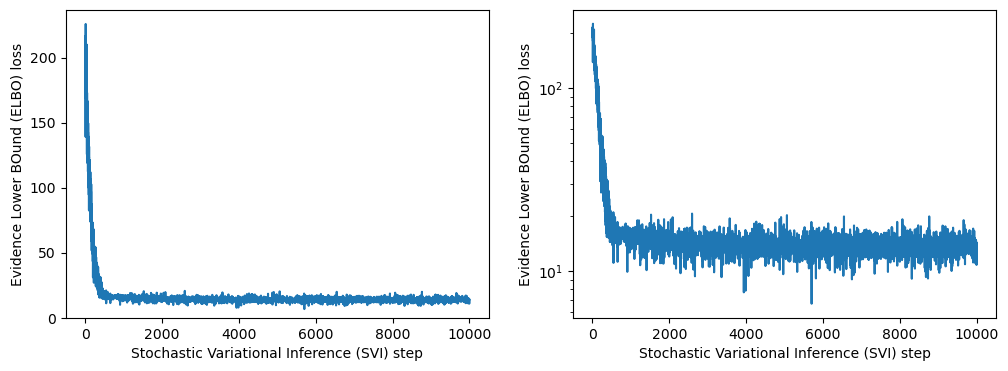

In [29]:
# Plot loss curve
plt.subplots(figsize=(12, 4))
for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.plot(losses)
    plt.xlabel('Stochastic Variational Inference (SVI) step')
    plt.ylabel('Evidence Lower BOund (ELBO) loss')
    plt.ylim(bottom=0.) if i==0 else plt.yscale('log')
plt.show()

In [30]:
# Look at inferred parameters
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name).data.cpu().numpy())

AutoNormal.locs.bias -0.4788496
AutoNormal.scales.bias 0.42165583
AutoNormal.locs.slope 2.1684086
AutoNormal.scales.slope 0.11592141


In [31]:
# Sample from variational inference distributions
nsamples = int(1e3)
with pyro.plate('samples', nsamples, dim=-1):
    samples = guide(x_torch)
if wandb_run:
    for bias, slope in zip(samples['bias'], samples['slope']):
        wandb.log({'bias': bias, 'slope': slope})
bias = samples['bias'].detach().numpy() # NOTE: Convert to numpy here
slope = samples['slope'].detach().numpy()

In [32]:
# Functions for plotting

def analytical_covariance(x, y, sigma, alpha, verbose=False):
    
    # Analytical expression for the covariance
    # NOTE: From the previous questions you should be able to fill this in
    
    # Reshaping
    x_mat = np.zeros((len(x), 2))
    x_mat[:, 0] = np.ones(len(x))
    x_mat[:, 1] = x
    
    y_mat = np.zeros((len(y), 1))
    y_mat[:,0] = y
    Alpha = np.identity(2)*alpha
    
    pre = np.matmul(np.transpose(x_mat), x_mat)/np.power(sigma, 2) + Alpha
    
    return np.transpose(np.linalg.inv(pre))

def analytical_mean(x, y, sigma, alpha, verbose=False):
    # Analytical expression for the mean
    # NOTE: From the previous questions you should be able to fill this in
    
    # Reshaping
    x_mat = np.zeros((len(x), 2))
    x_mat[:, 0] = np.ones(len(x))
    x_mat[:, 1] = x
    
    y_mat = np.zeros((len(y), 1))
    y_mat[:,0] = y
    Alpha = np.identity(2)*alpha
    
    pre = np.matmul(np.transpose(x_mat), x_mat)/np.power(sigma, 2) + Alpha
    cov = np.linalg.inv(pre)
    
    mu = np.matmul(np.matmul(cov, np.transpose(x_mat)), y_mat)/np.power(sigma,2)
    mu = mu.flatten()

    return mu
    

def get_distribution(plt, mu, sig, N=200):
    # Distribution for 1D marginals
    xlim = plt.gca().get_xlim()
    x = np.linspace(xlim[0], xlim[1], N)
    rv = norm(mu, sig)
    f = rv.pdf(x)
    return x, f

def get_contours(plt, mu, cov, N=200):
    # Contours for 2D posterior
    xlim = plt.gca().get_xlim(); ylim = plt.gca().get_ylim()
    X = np.linspace(xlim[0], xlim[1], N)
    Y = np.linspace(ylim[0], ylim[1], N)
    X, Y = np.meshgrid(X, Y); pos = np.dstack((X, Y))
    rv = multivariate_normal(mu, cov)
    Z = rv.pdf(pos)
    return X, Y, Z

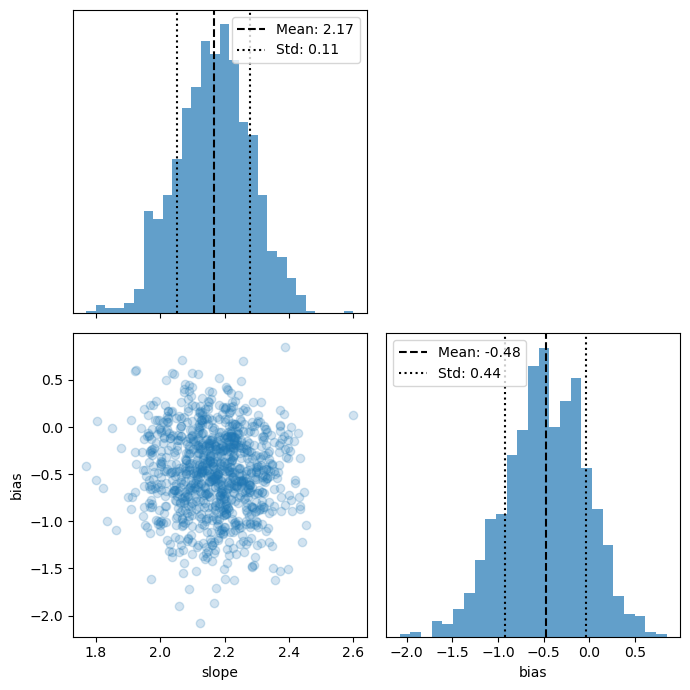

In [33]:
# Intialize
plot_analytical = False # NOTE: Turn this on if you figure out what the analytical result is
plt.subplots(figsize=(7, 7))
if plot_analytical:
    mu = analytical_mean(x_numpy, y_numpy, sigma, alpha)
    cov = analytical_covariance(x_numpy, y_numpy, sigma, alpha)

# Slope histogram
plt.subplot(2, 2, 1)
plt.hist(slope, density=True, bins='auto', alpha=0.7)
plt.axvline(slope.mean(), color='black', ls='--', label='Mean: %1.2f'%slope.mean())
plt.axvline(slope.mean()-slope.std(), color='black', ls=':', label='Std: %1.2f'%slope.std())
plt.axvline(slope.mean()+slope.std(), color='black', ls=':')
if plot_analytical:
    x, f = get_distribution(plt, mu[0], np.sqrt(cov[0, 0]))
    plt.plot(x, f, color='black', label='analytical')
plt.gca().set_xticklabels([])
plt.yticks([])
plt.legend()

# Bias histogram
plt.subplot(2, 2, 4)
plt.hist(bias, density=True, bins='auto', alpha=0.7)
plt.axvline(bias.mean(), color='black', ls='--', label='Mean: %1.2f'%bias.mean())
plt.axvline(bias.mean()-bias.std(), color='black', ls=':', label='Std: %1.2f'%bias.std())
plt.axvline(bias.mean()+bias.std(), color='black', ls=':')
if plot_analytical:
    x, f = get_distribution(plt, mu[1], np.sqrt(cov[1, 1]))
    plt.plot(x, f, color='black', label='analytical')
plt.xlabel('bias')
plt.yticks([])
plt.legend()

# Slope vs. bias scatter
plt.subplot(2, 2, 3)
plt.scatter(slope, bias, alpha=0.2)
if plot_analytical:
    X, Y, Z = get_contours(plt, mu, cov)
    plt.contour(X, Y, Z, colors='black', alpha=0.9, levels=3)
plt.xlabel('slope')
plt.ylabel('bias')

# Finalize
plt.tight_layout()
plt.show()

In [34]:
# Calculate the covariance and correlation matrices of the samples
cov = np.cov(np.stack([bias, slope]))
print('Covariance matrix:\n', cov)
r = np.corrcoef(bias, slope)
print('Correlation matrix:\n', r)

Covariance matrix:
 [[ 0.19543316 -0.0025119 ]
 [-0.0025119   0.01307703]]
Correlation matrix:
 [[ 1.         -0.04968764]
 [-0.04968764  1.        ]]


In [35]:
# Posterior predictive
x_new = tc.tensor([0.])
n = int(1e3)

# Calculate the posterior predictive at the new data point
ys_new = []
for _ in range(n):
    bias_sampled = random.choice(bias)
    slope_sampled = random.choice(slope)
    
    y_pred = bias_sampled + slope_sampled * x_new  
    ys_new.append(y_pred.item())
    continue

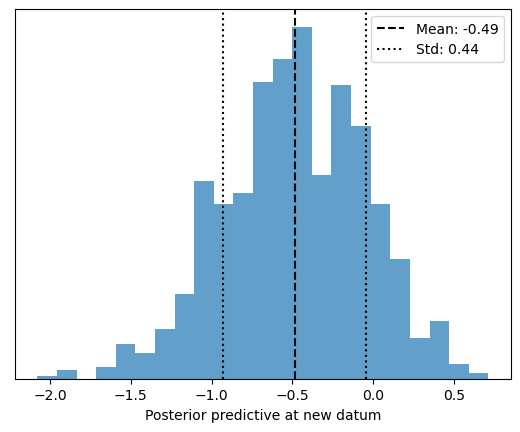

In [36]:
# Plot posterior predictive
plt.hist(ys_new, bins='auto', density=True, alpha=0.7)
mean = np.mean(ys_new); std = np.std(ys_new)
plt.axvline(mean, color='black', ls='--', label='Mean: %1.2f'%(mean))
plt.axvline(mean-std, color='black', ls=':', label='Std: %1.2f'%(std))
plt.axvline(mean+std, color='black', ls=':')
plt.xlabel('Posterior predictive at new datum')
plt.yticks([])
plt.legend()
if wandb_run: wandb.log({'Question 5; predictive at new datum': wandb.Image(plt)})
plt.show()

In [37]:
# Regression model
def regression(x, slope, bias):
    return bias + x*slope

In [38]:
# Data for posterior predictive
xmin = 0.; xmax = 7.; nx = 17
x = np.linspace(xmin, xmax, nx)
ys = []
for s, b in zip(slope, bias):
    y = regression(x, s, b)
    ys.append(y)
ys = np.array(ys)

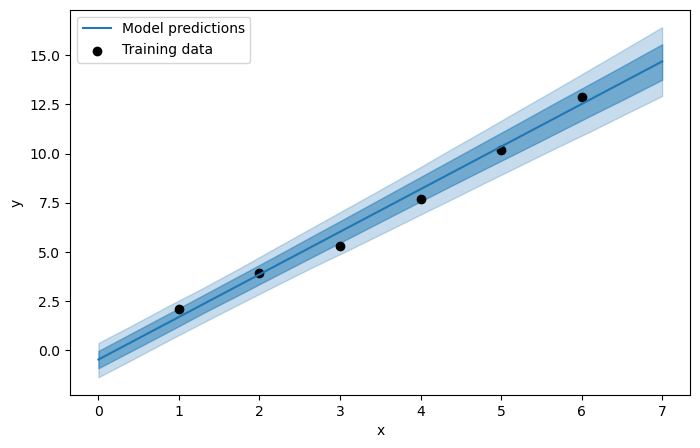

In [39]:
# Plot full posterior predictive
plt.figure(figsize=(8, 5))
plt.fill_between(x, np.percentile(ys, 2.28, axis=0), np.percentile(ys, 97.72, axis=0), color='C0', alpha=0.25) # 2-sigma
plt.fill_between(x, np.percentile(ys, 15.87, axis=0), np.percentile(ys, 84.13, axis=0), color='C0', alpha=0.5) # 1-sigma
plt.plot(x, ys.mean(axis=0), color='C0', label='Model predictions')
plt.scatter(x_numpy, y_numpy, marker='o', color='black', label='Training data')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
if wandb_run: wandb.log({'Question 5; predictive': wandb.Image(plt)})
plt.show()

In [40]:
# Finalise weights & biases
if wandb_run:
    data = [[j, s, b] for j, (s, b) in enumerate(zip(slope, bias))]
    table = wandb.Table(data=data, columns=['sample', 'slope', 'bias'])
    wandb_log = {}
    wandb_log['Question 5; slope'] = wandb.plot.histogram(table, value='slope', title='Question 5; slope')
    wandb_log['Question 5; bias'] = wandb.plot.histogram(table, value='bias', title='Question 5; bias')
    wandb_log['Question 5; scatter'] = wandb.plot.scatter(table, x='slope', y='bias', title='Question 5; slope vs. bias')
    wandb.log(wandb_log)
    wandb.finish()

bias,▄▇▆▅▂▃▆▁▆▅▅▄█▆▅▅▆▆▅▄▅▆▃▃▆▇▆▃█▄▆▆▂▅▄█▄▆▅▃
loss,█▁▁▁▁▁▁▁▁▁
slope,▄▆▆▃▃▄▂▃▄▃▅▄█▂▅▂▃▄▂▄▅▄▃▅▄▄▂▃▄▄▄▅▄▄▄▆▂▁▄▂
bias,0.08635
loss,14.27566
slope,2.21134
